In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.sql.functions import col, sum, count
import pyspark.pandas as ps
import findspark
findspark.init()

C:\Users\DELL\anaconda3\lib\site-packages\pyspark\pandas\__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
pd.pandas.set_option('display.max_columns',None)

### Bank Full (dataset-1)

In [5]:
bank_full = spark.read.csv('bank-full.csv',header=True,inferSchema=True)

In [6]:
bank_full.count()

45211

In [7]:
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
bank_full.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [9]:
new_cols = ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor_3m", "nr_employed"]
for column in new_cols:
    bank_full = bank_full.withColumn(column, bank_full["poutcome"]+1)

In [10]:
display(bank_full.limit(5))

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [11]:
def year_mapper(data, start_yr, end_yr):
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc=0, column="year", value=0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > end_yr:
            break

    return new_data

In [12]:
import warnings
# Use default index prevent overhead.
ps.set_option("compute.default_index_type", "distributed")

warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

# To speed up dataset processing
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

bank_full_pdf = bank_full.toPandas()

# Apply the function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008, 2010)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_full = spark.createDataFrame(new_pandas_df)


In [13]:
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,null,null,null,null,null
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,null,null,null,null,null
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,null,null,null,null,null
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,null,null,null,null,null
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,null,null,null,null,null


In [14]:
counts = bank_full.groupBy("year").count()
counts.show()

+----+-----+
|year|count|
+----+-----+
|2008|27729|
|2009|14862|
|2010| 2620|
+----+-----+



In [15]:
from pyspark.sql.types import IntegerType

### Index mapper

In [16]:
def map_index(new_data):

    index_2008 = {"may":{"emp_var_rate":1.1, "cons_price_idx":93.994, "cons_conf_idx":-36.4, "euribor_3m":4.85, "nr_employed":5191},
                 "jun":{"emp_var_rate":1.4, "cons_price_idx":94.465, "cons_conf_idx":-41.8, "euribor_3m":4.86, "nr_employed":5228.1},
                 "jul":{"emp_var_rate":1.4, "cons_price_idx":93.918, "cons_conf_idx":-42.7, "euribor_3m":4.96, "nr_employed":5228.1},
                 "aug":{"emp_var_rate":1.4, "cons_price_idx":93.444, "cons_conf_idx":-36.1, "euribor_3m":4.965, "nr_employed":5228.1},
                 "oct":{"emp_var_rate":-0.1, "cons_price_idx":93.798, "cons_conf_idx":-40.4, "euribor_3m":5, "nr_employed":5195.8},
                 "nov":{"emp_var_rate":-0.1, "cons_price_idx":93.2, "cons_conf_idx":-42, "euribor_3m":4.406, "nr_employed":5195.8},
                 "dec":{"emp_var_rate":-0.2, "cons_price_idx":92.75, "cons_conf_idx":-45.9, "euribor_3m":3.563, "nr_employed":5176.3}}

    index_2009 = {"jan":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "feb":{"emp_var_rate":-0.2, "nr_employed":5176.3},
                  "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.84, "cons_conf_idx":-50, "euribor_3m":1.811, "nr_employed":5099.1},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.075, "cons_conf_idx":-47.1, "euribor_3m":1.498, "nr_employed":5099.1},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":92.89, "cons_conf_idx":-46.2, "euribor_3m":1.334, "nr_employed":5099.1},
                 "jun":{"emp_var_rate":-2.9, "cons_price_idx":92.963, "cons_conf_idx":-40.8, "euribor_3m":1.26, "nr_employed":5076.2},
                 "jul":{"emp_var_rate":-2.9, "cons_price_idx":93.469, "cons_conf_idx":-33.6, "euribor_3m":1.072, "nr_employed":5076.2},
                 "aug":{"emp_var_rate":-2.9, "cons_price_idx":92.201, "cons_conf_idx":-31.4, "euribor_3m":0.884, "nr_employed":5076.2},
                 "sep":{"emp_var_rate":-3.4, "cons_price_idx":92.379, "cons_conf_idx":-29.8, "euribor_3m":0.813, "nr_employed":5017.5},
                 "oct":{"emp_var_rate":-3.4, "cons_price_idx":92.431, "cons_conf_idx":-26.9, "euribor_3m":0.754, "nr_employed":5017.5},
                 "nov":{"emp_var_rate":-3.4, "cons_price_idx":92.649, "cons_conf_idx":-30.1, "euribor_3m":0.722, "nr_employed":5017.5},
                 "dec":{"emp_var_rate":-3, "cons_price_idx":92.713, "cons_conf_idx":-33, "euribor_3m":0.718, "nr_employed":5023.5}}

    index_2010 = {"jan":{"emp_var_rate":-3, "nr_employed":5023.5},
                  "feb":{"emp_var_rate":-3, "nr_employed":5023.5},
                   "mar":{"emp_var_rate":-1.8, "cons_price_idx":92.369, "cons_conf_idx":-34.8, "euribor_3m":0.655, "nr_employed":5008.7},
                  "apr":{"emp_var_rate":-1.8, "cons_price_idx":93.749, "cons_conf_idx":-34.6, "euribor_3m":0.64, "nr_employed":5008.7},
                  "may":{"emp_var_rate":-1.8, "cons_price_idx":93.876, "cons_conf_idx":-40, "euribor_3m":0.668, "nr_employed":5008.7},
                 "jun":{"emp_var_rate":-1.7, "cons_price_idx":94.055, "cons_conf_idx":-39.8, "euribor_3m":0.704, "nr_employed":4991.6},
                 "jul":{"emp_var_rate":-1.7, "cons_price_idx":94.215, "cons_conf_idx":-40.3, "euribor_3m":0.79, "nr_employed":4991.6},
                 "aug":{"emp_var_rate":-1.7, "cons_price_idx":94.027, "cons_conf_idx":-38.3, "euribor_3m":0.898, "nr_employed":4991.6},
                 "sep":{"emp_var_rate":-1.1, "cons_price_idx":94.199, "cons_conf_idx":-37.5, "euribor_3m":0.886, "nr_employed":4963.6},
                 "oct":{"emp_var_rate":-1.1, "cons_price_idx":94.601, "cons_conf_idx":-49.5, "euribor_3m":0.959, "nr_employed":4963.6},
                 "nov":{"emp_var_rate":-1.1, "cons_price_idx":94.767, "cons_conf_idx":-50.8, "euribor_3m":1.05, "nr_employed":4963.6}}

    indx = [index_2008, index_2009, index_2010]
    years = [2008, 2009, 2010]
    
    for i in range(len(years)):
        for months, indexes in indx[i].items():
            for index, index_val in indexes.items():
                new_data = new_data.withColumn(index, 
                    when((col('year') == years[i]) & (col('month') == months), index_val).otherwise(col(index))) 
    return new_data

In [17]:
bank_full = map_index(new_data = bank_full)
display(bank_full.limit(5))

year,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed
2008,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0
2008,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1.1,93.994,-36.4,4.85,5191.0


### Bank Full Dataset (dataset-2)

In [18]:
bank_add_full = spark.read.csv('bank-additional-full.csv', header=True, inferSchema=True)

In [19]:
display(bank_add_full.limit(5))

age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [20]:
def year_mapper(data, start_yr):
    month_lst = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

    # Make a copy of the original dataframe
    new_data = data.copy()

    # Insert a new "year" column filled with zeros
    new_data.insert(loc=0, column="year", value=0)

    # Set the first year to the start year
    current_year = int(start_yr)
    new_data.at[0, "year"] = current_year

    # Loop through the rows of the dataframe, updating the year column when the month changes
    for i in range(1, len(new_data)):
        # If the current month is earlier in the year than the previous month, increment the year
        if month_lst.index(new_data["month"][i]) < month_lst.index(new_data["month"][i-1]):
            current_year += 1

        new_data.at[i, "year"] = current_year

        # If the current year exceeds the end year, break out of the loop
        if current_year > 2010:
            break

    return new_data

In [21]:
# Use default index prevent overhead.
ps.set_option("compute.default_index_type", "distributed")

warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.

# To speed up dataset processing
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

bank_full_pdf = bank_add_full.toPandas()

# Apply the function to the Pandas DataFrame
new_pandas_df = year_mapper(bank_full_pdf, 2008)

# Convert the updated Pandas DataFrame back to a PySpark DataFrame
bank_add_full = spark.createDataFrame(new_pandas_df)

### replace values from 999 to -1

In [22]:
bank_add_full = bank_add_full.withColumn("pdays", when(col("pdays") == 999, -1).otherwise(col("pdays")))

### Renaming columns names and values

In [23]:
old_col_list = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
for i in range(0, len(old_col_list)):
    bank_add_full = bank_add_full.withColumnRenamed(old_col_list[i], new_cols[i])

In [24]:
old_edu = ["basic.4y", "high.school", "basic.6y", "basic.9y", "university.degree", "professional.course"]
new_edu = ["basic_4y", "high_school", "basic_6y", "basic_9y", "university_degree" ,"professional_course"]

for i in range(0,6):
    bank_add_full = bank_add_full.withColumn("education", when(col("education") == old_edu[i], new_edu[i]).otherwise(col("education")))

In [25]:
display(bank_add_full.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high_school,unknown,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high_school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high_school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [26]:
bank_full = bank_full.drop("balance", "day")

In [27]:
bank_add_full = bank_add_full.drop("day_of_week")

## Concat two dataframes

In [28]:
bank_data = bank_add_full.union(bank_full)

In [29]:
#bank_data_pdf = bank_data.toPandas()

In [30]:
#bank_data_pdf.to_parquet("bank_data_pdf_no_date.parquet")

In [31]:
#bank_data = spark.read.parquet('bank_data_pdf_no_date.parquet')

In [32]:
display(bank_add_full.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high_school,unknown,no,no,telephone,may,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high_school,no,yes,no,telephone,may,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic_6y,no,no,no,telephone,may,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high_school,no,no,yes,telephone,may,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [33]:
bank_data.count()

86399

In [34]:
#bank_data.summary()

In [35]:
cat_col = ["job","marital","education","default","housing","loan","contact","month","year","y"]
cont_col = ["age","duration","campaign","pdays","previous","emp_var_rate","cons_price_idx","cons_conf_idx","euribor_3m","nr_employed"]
categories = bank_data.select(cat_col)
continuous = bank_data.select(cont_col)

### value counts

In [36]:
for columns in categories:
    print("Column Name", columns)
    print("-----------------------")
    counts = bank_data.groupBy(columns).count()
    counts.show()
    print("     ")
    print("******************************************************")
    print("     ")

Column Name Column<'job'>
-----------------------
+-------------+-----+
|          job|count|
+-------------+-----+
|   management|12382|
|      retired| 3984|
|      unknown|  618|
|self-employed| 3000|
|      student| 1813|
|  blue-collar|18986|
| entrepreneur| 2943|
|       admin.|15593|
|   technician|14340|
|     services| 8123|
|    housemaid| 2300|
|   unemployed| 2317|
+-------------+-----+

     
******************************************************
     
Column Name Column<'marital'>
-----------------------
+--------+-----+
| marital|count|
+--------+-----+
| unknown|   80|
|divorced| 9819|
| married|52142|
|  single|24358|
+--------+-----+

     
******************************************************
     
Column Name Column<'education'>
-----------------------
+-------------------+-----+
|          education|count|
+-------------------+-----+
|professional_course| 5243|
|           basic_4y| 4176|
|            unknown| 3588|
|           basic_9y| 6045|
|         illiterate

In [37]:
bank_data = bank_data.withColumn("job", when(col("job") == "admin.", "admin").otherwise(col("job")))

In [38]:
counts = bank_data.groupBy("job").count()
counts.show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management|12382|
|      retired| 3984|
|      unknown|  618|
|self-employed| 3000|
|      student| 1813|
|  blue-collar|18986|
| entrepreneur| 2943|
|   technician|14340|
|        admin|15593|
|     services| 8123|
|    housemaid| 2300|
|   unemployed| 2317|
+-------------+-----+



In [39]:
for column in bank_data.columns:
    bank_data = bank_data.withColumn(column, when(col(column).isin("unknown", "nonexistent"), None).otherwise(col(column)))

In [40]:
display(bank_add_full.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,housemaid,married,basic_4y,no,no,no,telephone,may,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,57,services,married,high_school,unknown,no,no,telephone,may,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,37,services,married,high_school,no,yes,no,telephone,may,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,40,admin.,married,basic_6y,no,no,no,telephone,may,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2008,56,services,married,high_school,no,no,yes,telephone,may,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Checking for null values

In [41]:
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|618|     80|     3588|   8597|    990| 990|  13020|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [42]:
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|             0|         4052|      4052|       4052|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing continue variables

In [43]:
from pyspark.sql.functions import mean

# calculate the mean of non-null values in columns col1 and col2
mean_dict = bank_data.select(*(mean(c).alias(c) for c in cont_col)).first().asDict()

# replace null values with the mean in columns col1 and col2
bank_data = bank_data.fillna(mean_dict)

In [44]:
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in continuous.columns]).show()

+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|age|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+
|  0|       0|       0|    0|       0|           0|             0|            0|         0|          0|
+---+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+



### Replacing categorical variables

In [45]:
bank_data = bank_data.drop("poutcome")

In [46]:
for column in cat_col:
    mode_value = bank_data.first()[column]
    bank_data = bank_data.fillna({column:mode_value})

In [47]:
bank_data.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in categories.columns]).show()

+---+-------+---------+-------+-------+----+-------+-----+----+---+
|job|marital|education|default|housing|loan|contact|month|year|  y|
+---+-------+---------+-------+-------+----+-------+-----+----+---+
|  0|      0|        0|      0|      0|   0|      0|    0|   0|  0|
+---+-------+---------+-------+-------+----+-------+-----+----+---+



In [48]:
pdf=bank_data.toPandas()

<AxesSubplot:>

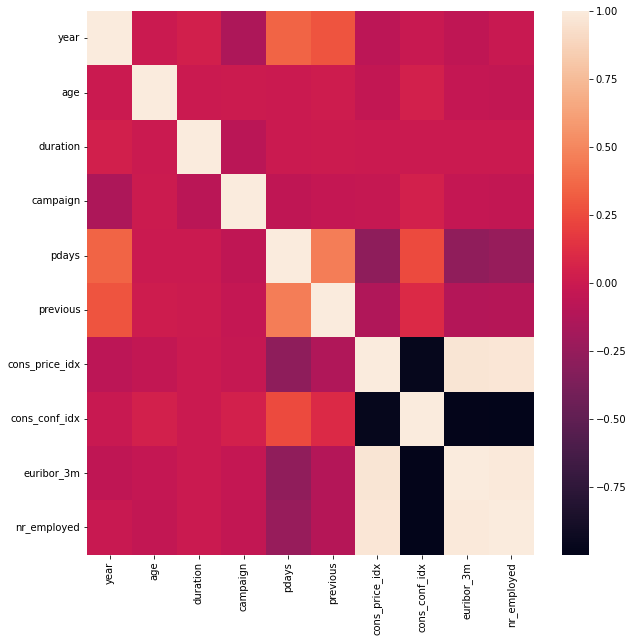

In [49]:
correlation = pdf.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation)

## Data Preprocessing

In [50]:
# Creating a dictionary for converting categorical textual data entries
# into categorical numeric on basis of job profile
job_dict = {"entrepreneur":11, "self-employed":10, "admin":9, "management":8, "services":7, 
       "technician":6, "blue-collar":5, "housemaid":4, "retired":3, "student":2, "unemployed":1}

for key, value in job_dict.items():
    bank_data = bank_data.withColumn("job", when(bank_data["job"] == key, int(value)).otherwise(bank_data["job"]))

In [51]:
marital_dict = {"married":3, "single":2, "divorced":1}

for key, value in marital_dict.items():
    bank_data = bank_data.withColumn("marital", when(bank_data["marital"] == key, value).otherwise(bank_data["marital"]))

In [52]:
edu_dict = {"professional_course":10, "university_degree":9, "tertiary":8, "secondary":7, 
       "high_school":6, "basic_9y":5, "basic_6y":4, "primary":3, "basic_4y":2, "illiterate":1}

for key, value in edu_dict.items():
    bank_data = bank_data.withColumn("education", when(bank_data["education"] == key, value).otherwise(bank_data["education"]))

In [53]:
y_dict = {"yes":1, "no":0}

for key, value in y_dict.items():
    bank_data = bank_data.withColumn("y", when(bank_data["y"] == key, value).otherwise(bank_data["y"]))

In [54]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
2008,56,4,3,2,no,no,no,telephone,may,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0
2008,57,7,3,6,no,no,no,telephone,may,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0
2008,37,7,3,6,no,yes,no,telephone,may,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0
2008,40,9,3,4,no,no,no,telephone,may,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0
2008,56,7,3,6,no,no,yes,telephone,may,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0


In [55]:
quarter_dict = {"jan":"Q1", "feb":"Q1", "mar":"Q1", "apr":"Q2", "may":"Q2", "jun":"Q2", 
                "jul":"Q3", "aug":"Q3", "sep":"Q3", "oct":"Q4", "nov":"Q4", "dec":"Q4"}

for key, value in quarter_dict.items():
    bank_data = bank_data.withColumn("month", when(bank_data["month"] == key, value).otherwise(bank_data["month"]))

In [56]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: string (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)



In [57]:
bank = bank_data

In [58]:
one_hot_cols = ["default", "housing", "loan"]

for i in one_hot_cols:
    bank = bank.withColumn(i, when(col(i) == "yes", 1).
                              when(col(i) == "no", 0).
                              otherwise(col(i)))
    
bank = bank.withColumn("contact", when(col("contact") == "telephone", 1)
                                  .when(col("contact") == "cellular", 0)
                                  .otherwise(col("contact")))

In [59]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='month', outputCol='class_numeric')
indexer_fitted = indexer.fit(bank)
df_indexed = indexer_fitted.transform(bank)

from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=['class_numeric'], outputCols=['class_onehot'])
df_onehot = encoder.fit(df_indexed).transform(df_indexed)

from pyspark.ml.functions import vector_to_array
df_col_onehot = df_onehot.select('*', vector_to_array('class_onehot').alias('Quarter'))

import pyspark.sql.functions as F
num_categories = len(df_col_onehot.first()['Quarter'])
cols_expanded = [(F.col('Quarter')[i].alias(f'{indexer_fitted.labels[i]}')) for i in range(num_categories)]
bank_df = df_col_onehot.select("year","age","job","marital","education","default","housing","loan","contact",
                                      "month","duration","campaign","pdays","previous","emp_var_rate","cons_price_idx",
                                      "cons_conf_idx","euribor_3m","nr_employed","y",*cols_expanded)


In [60]:
display(bank_df.limit(5))

year,age,job,marital,education,default,housing,loan,contact,month,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,56,4,3,2,0,0,0,1,Q2,261,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,57,7,3,6,0,0,0,1,Q2,149,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,37,7,3,6,0,1,0,1,Q2,226,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,40,9,3,4,0,0,0,1,Q2,151,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,56,7,3,6,0,0,1,1,Q2,307,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0


In [61]:
bank_df.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = false)
 |-- marital: string (nullable = false)
 |-- education: string (nullable = false)
 |-- default: string (nullable = false)
 |-- housing: string (nullable = false)
 |-- loan: string (nullable = false)
 |-- contact: string (nullable = false)
 |-- month: string (nullable = false)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: string (nullable = false)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: string (nullable = false)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



In [86]:
bank_data = bank_df

In [87]:
bank_data = bank_data.drop("month")

In [88]:
column_types = bank_data.dtypes
# Filter the list to only include the string datatype columns

string_columns = [column[0] for column in column_types if column[1] == "string"]
print(string_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'emp_var_rate', 'y']


In [89]:
for cols in string_columns:
# Change the datatype of the "age" column to integer
    bank_data = bank_data.withColumn(cols, bank_data[cols].cast("int"))

In [90]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,56,4,3,2,0,0,0,1,261,1,-1,0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,57,7,3,6,0,0,0,1,149,1,-1,0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,37,7,3,6,0,1,0,1,226,1,-1,0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,40,9,3,4,0,0,0,1,151,1,-1,0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,56,7,3,6,0,0,1,1,307,1,-1,0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0


In [91]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: integer (nullable = true)
 |-- job: integer (nullable = true)
 |-- marital: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- default: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- emp_var_rate: integer (nullable = true)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: integer (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



### Outliers

In [92]:
out = bank_data.toPandas()

In [93]:
outliers_columns = ["age","duration","campaign","pdays","previous"]

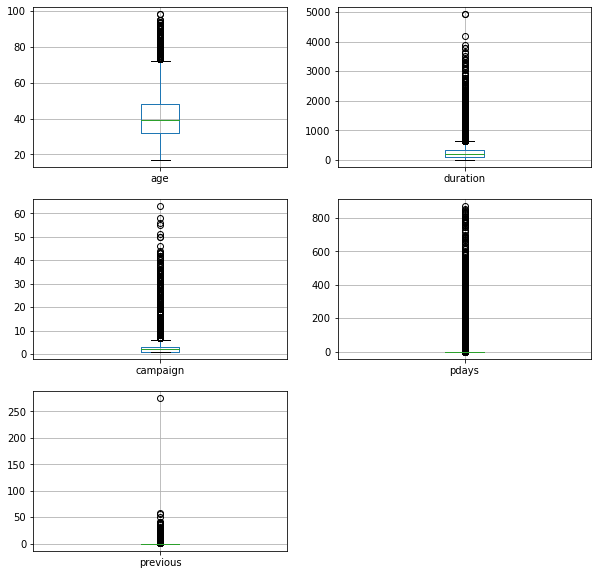

In [94]:
def plot_box():
    plt.figure(figsize=(10,10))
    plt.subplot(3,2,1)
    out.boxplot(column=["age"])

    plt.subplot(3,2,2)
    out.boxplot(column=["duration"])

    plt.subplot(3,2,3)
    out.boxplot(column=["campaign"])

    plt.subplot(3,2,4)
    out.boxplot(column=["pdays"])

    plt.subplot(3,2,5)
    out.boxplot(column=["previous"])
           
plot_box()

In [95]:
max_out_limit = []
for cols in outliers_columns:
    quantiles = bank_data.approxQuantile(cols, [0.25, 0.5, 0.75], 0.01)
    
    q3 = quantiles[2]
    q1 = quantiles[0]
    iqr = q3 - q1
    iqr = iqr*1.5
    max_limit = q3 + iqr
    min_limit = q1 - iqr
    max_out_limit.append(max_limit)
    
    print(cols, "max_limit: ",max_limit,"      min_limit: ",min_limit)
else:
    print("------------------------------------------")
    print(max_out_limit)



age max_limit:  69.5       min_limit:  9.5
duration max_limit:  629.5       min_limit:  -214.5
campaign max_limit:  6.0       min_limit:  -2.0
pdays max_limit:  -1.0       min_limit:  -1.0
previous max_limit:  0.0       min_limit:  0.0
------------------------------------------
[69.5, 629.5, 6.0, -1.0, 0.0]


In [96]:
for i, j in zip(outliers_columns, max_out_limit):
    bank_data = bank_data.withColumn(i, 
                    when((col(i) >= j), j).otherwise(col(i))) 

In [97]:
out = bank_data.toPandas()

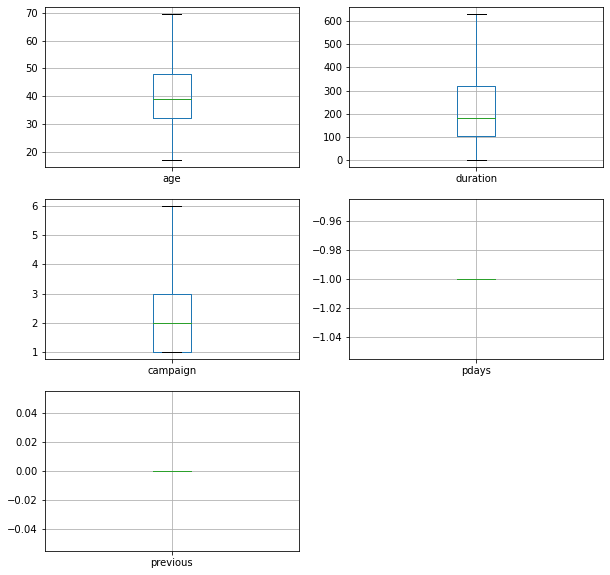

In [98]:
plot_box()

In [99]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: double (nullable = true)
 |-- job: integer (nullable = true)
 |-- marital: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- default: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- emp_var_rate: integer (nullable = true)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: integer (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



In [100]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,56.0,4,3,2,0,0,0,1,261.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,57.0,7,3,6,0,0,0,1,149.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,37.0,7,3,6,0,1,0,1,226.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,40.0,9,3,4,0,0,0,1,151.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,56.0,7,3,6,0,0,1,1,307.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0


In [101]:
features = []
for columns in bank_data.columns:
    features.append(columns)
else:
    print(features)

['year', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'y', 'Q2', 'Q3', 'Q4']


from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Select the numerical columns

# Create a vector assembler to combine the numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Transform the DataFrame to create the numerical features vector
bank_data = assembler.transform(bank_data)

# Apply MinMaxScaler to the numerical features vector
scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")
scaler_model = scaler.fit(bank_data)
df = scaler_model.transform(bank_data)

df = df.drop("numerical_features")

# Drop the original numerical columns and keep only the scaled numerical features
bank_data = df.drop(*numerical_cols).withColumnRenamed("scaled_numerical_features", "features")


In [102]:
display(bank_data.limit(5))

year,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,Q2,Q3,Q4
2008,56.0,4,3,2,0,0,0,1,261.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,57.0,7,3,6,0,0,0,1,149.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,37.0,7,3,6,0,1,0,1,226.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,40.0,9,3,4,0,0,0,1,151.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0
2008,56.0,7,3,6,0,0,1,1,307.0,1.0,-1.0,0.0,1,93.994,-36.4,4.857,5191.0,0,1.0,0.0,0.0


In [103]:
bank_data.printSchema()

root
 |-- year: long (nullable = false)
 |-- age: double (nullable = true)
 |-- job: integer (nullable = true)
 |-- marital: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- default: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- contact: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- campaign: double (nullable = true)
 |-- pdays: double (nullable = true)
 |-- previous: double (nullable = true)
 |-- emp_var_rate: integer (nullable = true)
 |-- cons_price_idx: double (nullable = false)
 |-- cons_conf_idx: double (nullable = false)
 |-- euribor_3m: double (nullable = false)
 |-- nr_employed: double (nullable = false)
 |-- y: integer (nullable = true)
 |-- Q2: double (nullable = true)
 |-- Q3: double (nullable = true)
 |-- Q4: double (nullable = true)



In [104]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

In [107]:
assembler = VectorAssembler(inputCols=features, outputCol='features')

In [109]:
bank_transform = assembler.transform(bank_data)

In [112]:
train_data, test_data = bank_transform.randomSplit([0.80, 0.20], seed = 0)
display(train_data.limit(5))

Py4JJavaError: An error occurred while calling o3172.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 209.0 failed 1 times, most recent failure: Lost task 4.0 in stage 209.0 (TID 612) (DESKTOP-8RU3UAH executor driver): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4594/0x0000000801dbb790: (struct<year_double_VectorAssembler_a541250db629:double,age:double,job_double_VectorAssembler_a541250db629:double,marital_double_VectorAssembler_a541250db629:double,education_double_VectorAssembler_a541250db629:double,default_double_VectorAssembler_a541250db629:double,housing_double_VectorAssembler_a541250db629:double,loan_double_VectorAssembler_a541250db629:double,contact_double_VectorAssembler_a541250db629:double,duration:double,campaign:double,pdays:double,previous:double,emp_var_rate_double_VectorAssembler_a541250db629:double,cons_price_idx:double,cons_conf_idx:double,euribor_3m:double,nr_employed:double,y_double_VectorAssembler_a541250db629:double,Q2:double,Q3:double,Q4:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4594/0x0000000801dbb790: (struct<year_double_VectorAssembler_a541250db629:double,age:double,job_double_VectorAssembler_a541250db629:double,marital_double_VectorAssembler_a541250db629:double,education_double_VectorAssembler_a541250db629:double,default_double_VectorAssembler_a541250db629:double,housing_double_VectorAssembler_a541250db629:double,loan_double_VectorAssembler_a541250db629:double,contact_double_VectorAssembler_a541250db629:double,duration:double,campaign:double,pdays:double,previous:double,emp_var_rate_double_VectorAssembler_a541250db629:double,cons_price_idx:double,cons_conf_idx:double,euribor_3m:double,nr_employed:double,y_double_VectorAssembler_a541250db629:double,Q2:double,Q3:double,Q4:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more


Py4JJavaError: An error occurred while calling o3172.getRowsToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 210.0 failed 1 times, most recent failure: Lost task 4.0 in stage 210.0 (TID 618) (DESKTOP-8RU3UAH executor driver): org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4594/0x0000000801dbb790: (struct<year_double_VectorAssembler_a541250db629:double,age:double,job_double_VectorAssembler_a541250db629:double,marital_double_VectorAssembler_a541250db629:double,education_double_VectorAssembler_a541250db629:double,default_double_VectorAssembler_a541250db629:double,housing_double_VectorAssembler_a541250db629:double,loan_double_VectorAssembler_a541250db629:double,contact_double_VectorAssembler_a541250db629:double,duration:double,campaign:double,pdays:double,previous:double,emp_var_rate_double_VectorAssembler_a541250db629:double,cons_price_idx:double,cons_conf_idx:double,euribor_3m:double,nr_employed:double,y_double_VectorAssembler_a541250db629:double,Q2:double,Q3:double,Q4:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (VectorAssembler$$Lambda$4594/0x0000000801dbb790: (struct<year_double_VectorAssembler_a541250db629:double,age:double,job_double_VectorAssembler_a541250db629:double,marital_double_VectorAssembler_a541250db629:double,education_double_VectorAssembler_a541250db629:double,default_double_VectorAssembler_a541250db629:double,housing_double_VectorAssembler_a541250db629:double,loan_double_VectorAssembler_a541250db629:double,contact_double_VectorAssembler_a541250db629:double,duration:double,campaign:double,pdays:double,previous:double,emp_var_rate_double_VectorAssembler_a541250db629:double,cons_price_idx:double,cons_conf_idx:double,euribor_3m:double,nr_employed:double,y_double_VectorAssembler_a541250db629:double,Q2:double,Q3:double,Q4:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 17 more
